<center><h1>Incorporate n-grams with word embeddings</h1></center>

How can we incorporate N-Grams features with our word embedding, we use **convolution**.

<center><img src="https://cezannec.github.io/assets/cnn_text/conv_maxpooling_steps.gif"></center>

The window size indicate the N in N-gram, like for example if the kernel size is `3x300`, this means 3-grams model and so on 

In [1]:
import spacy
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

nlp = spacy.load("en_core_web_md")
dataset = pd.read_csv("chatbot-data.tsv", sep="\t")

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
dataset.head()

,Unnamed: 0,text,intent
0,0,hello there,greetings
1,1,good morning,greetings
2,2,welcome,greetings
3,3,"hi!, how are you",greetings
4,4,Hi there !!,greetings


In [3]:
def get_longest_text(texts):
    longest_input = 0
    for text in texts:
        text_len= len(text.split())
        longest_input = max(longest_input, text_len)
    return longest_input

In [4]:
longest_input = get_longest_text(dataset['text'])
longest_input

11

In [5]:
data_emb = np.zeros((len(dataset), longest_input, 300))
for i, text in enumerate(tqdm(nlp.pipe(dataset['text']), total=len(dataset))):
    for j, token in enumerate(text):
        data_emb[i, j] = token.vector

  0%|          | 0/35 [00:00<?, ?it/s]

In [6]:
# prepare y
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(dataset['intent'])
y_encoded = to_categorical(y_encoded)

In [7]:
y_encoded[:10]

array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [30]:
import tensorflow as tf

# define the network
inputs = tf.keras.layers.Input((longest_input, 300))
reshaped = tf.keras.layers.Reshape((longest_input, 300, 1))(inputs)


filters = [2, 3, 4]

# define the conv net
conv_1 = tf.keras.layers.Conv2D(100, (filters[0], 300), activation='relu')(reshaped)
conv_2 = tf.keras.layers.Conv2D(100, (filters[1], 300), activation='relu')(reshaped)
conv_3 = tf.keras.layers.Conv2D(100, (filters[2], 300), activation='relu')(reshaped)

# define max-pooling
pool_1 = tf.keras.layers.MaxPooling2D((longest_input - filters[0] + 1, 1), strides=(1,1))(conv_1)
pool_2 = tf.keras.layers.MaxPooling2D((longest_input - filters[1] + 1, 1), strides=(1,1))(conv_2)
pool_3 = tf.keras.layers.MaxPooling2D((longest_input - filters[2] + 1, 1), strides=(1,1))(conv_3)

# concatenate the convs
merged_tensor = tf.keras.layers.concatenate([pool_1, pool_2, pool_3], axis=1)

# now flatten them and add a dense layer
flatten = tf.keras.layers.Flatten()(merged_tensor)

# add a dense layer
clf = tf.keras.layers.Dense(100, activation='relu')(flatten)

# add final output
clf = tf.keras.layers.Dense(len(encoder.classes_), activation='softmax')(clf)

In [31]:
# compile the model
model = tf.keras.models.Model(inputs, clf)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 11, 300)]    0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 11, 300, 1)   0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 10, 1, 100)   60100       reshape_2[0][0]                  
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 9, 1, 100)    90100       reshape_2[0][0]                  
____________________________________________________________________________________________

In [32]:
# !pip install pydot graphviz

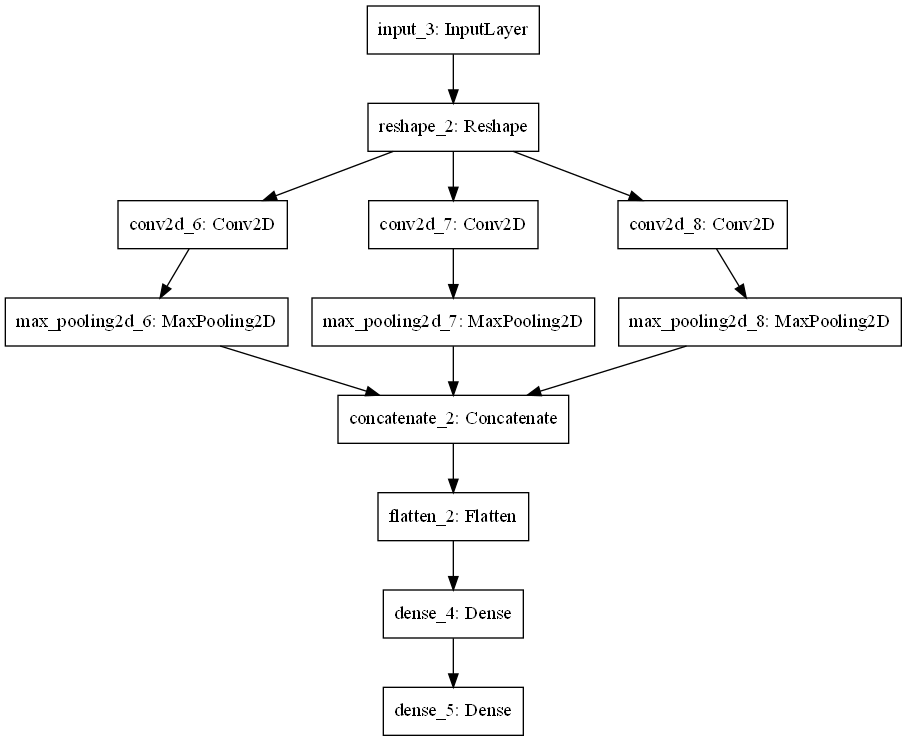

In [33]:
tf.keras.utils.plot_model(
    model, show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [34]:
# let's split the data and train our model
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_emb, y_encoded, test_size=.2)

In [39]:
# train our model
model.fit(x_train, y_train, epochs=1)

1/1 [==============================] - 0s 6ms/step - loss: 1.4245 - acc: 0.9643


In [40]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 11ms/step - loss: 1.6801 - acc: 0.4286


[1.6800525188446045, 0.4285714328289032]

Let's make a prediction function

In [15]:
encoder.classes_[4]

'reserve_enq'

In [16]:
text = "Hello do you have python courses?"
text_v = np.zeros((1, longest_input, 300))
for i, token in enumerate(nlp(text)):
    if i>=longest_input:
        break
    text_v[0, i] = token.vector
predictions = model.predict(text_v)
predictions

array([[8.6449915e-01, 9.8544478e-02, 1.3815803e-03, 3.0449471e-02,
        9.3967922e-04, 2.1344087e-05, 4.1642380e-03]], dtype=float32)

In [17]:
np.argmax(predictions)

0

In [18]:
for label, prob in zip(encoder.classes_, predictions[0]):
    print((label, round(prob, 3)))

('availability_enq', 0.864)
('cost_enq', 0.099)
('duration_enq', 0.001)
('greetings', 0.03)
('reserve_enq', 0.001)
('start_enq', 0.0)
('thanks', 0.004)


In [19]:
def predict_n_gram(text):
    text_v = np.zeros((1, longest_input, 300))
    for i, token in enumerate(nlp(text)):
        if i>=longest_input:
            break
        text_v[0, i] = token.vector
    # predict the input 
    prediction = model.predict(text_v)
    label = encoder.classes_[np.argmax(prediction)]
    return label

In [20]:
predict_n_gram("how much for the french course?")

'cost_enq'